In [138]:
import phyre
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from PIL import Image
import os

In [100]:
get_n_rollouts = 5
eval_setup = 'ball_cross_template'
fold_id = 0 # one fold evaluation for simplicity

In [51]:
train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, fold_id)
print('Size of resulting splits -> train:', len(train_tasks), 'dev:',
      len(dev_tasks), 'test:', len(test_tasks))

Size of resulting splits -> train: 1600 dev: 400 test: 500


In [61]:
action_tier = phyre.eval_setup_to_action_tier(eval_setup)
print('Action tier for', eval_setup, 'is', action_tier)

tasks = train_tasks
# Create the simulator from the tasks and tier.
train_simulator = phyre.initialize_simulator(train_tasks, action_tier)
dev_simulator = phyre.initialize_simulator(dev_tasks, action_tier)
test_simulator = phyre.initialize_simulator(test_tasks, action_tier)

Action tier for ball_cross_template is ball


## Train Task Templates

Selected Templates


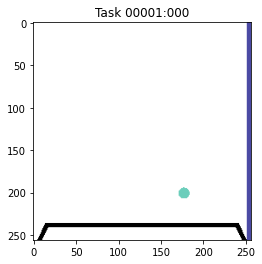

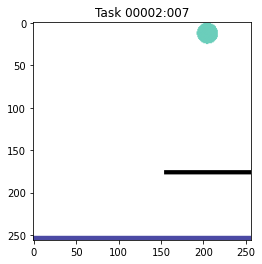

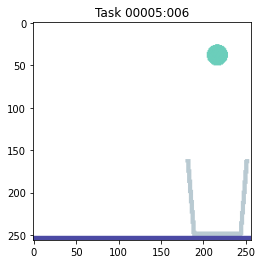

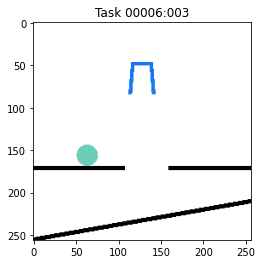

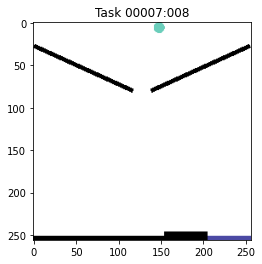

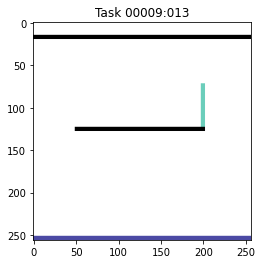

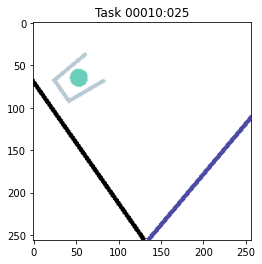

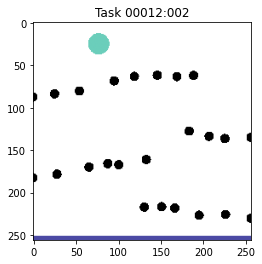

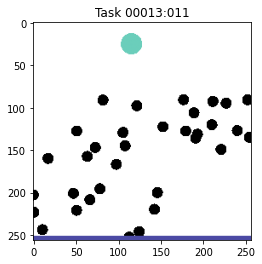

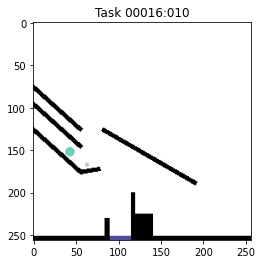

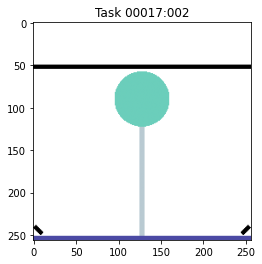

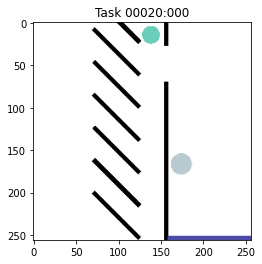

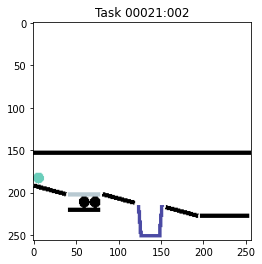

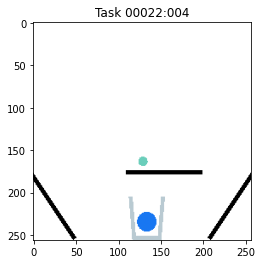

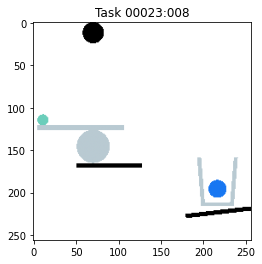

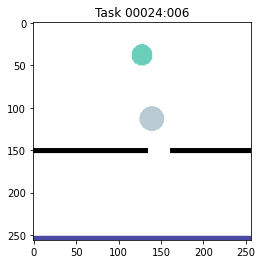

In [58]:
print("Selected Templates") # 100*x th image
simulator = train_simulator
tasks = train_tasks

for task_index in range(0, int(len(tasks)/100)):
    task_id = simulator.task_ids[task_index*100]
    initial_scene = simulator.initial_scenes[task_index*100]
    plt.imshow(phyre.observations_to_float_rgb(initial_scene))
    plt.title(f'Task {task_id}')
    plt.show()

## Dev Task Templates

Selected Templates


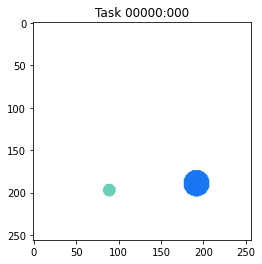

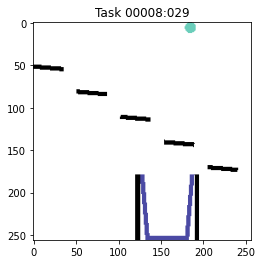

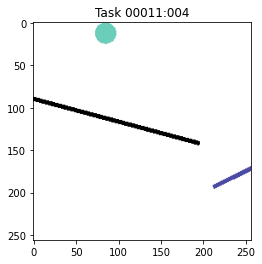

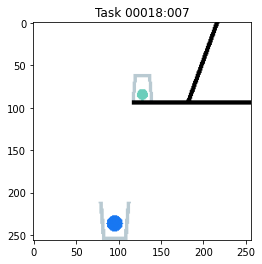

In [62]:
print("Selected Templates") # 100*x th image
simulator = dev_simulator
tasks = dev_tasks

for task_index in range(0, int(len(tasks)/100)):
    task_id = simulator.task_ids[task_index*100]
    initial_scene = simulator.initial_scenes[task_index*100]
    plt.imshow(phyre.observations_to_float_rgb(initial_scene))
    plt.title(f'Task {task_id}')
    plt.show()

## Test Task Templates

Selected Templates


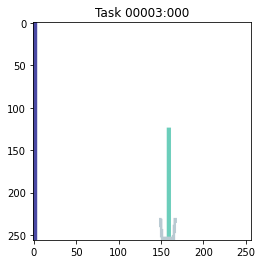

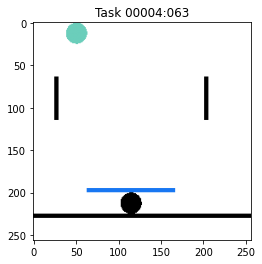

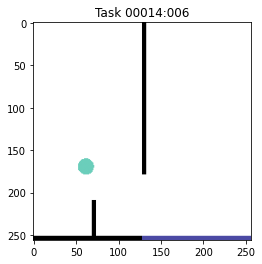

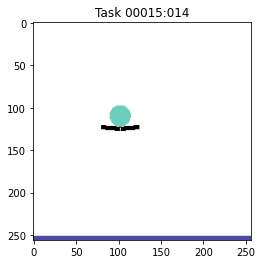

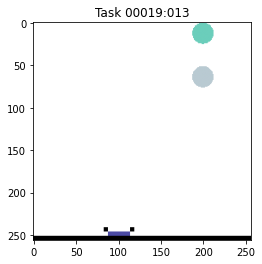

In [63]:
print("Selected Templates") # 100*x th image
simulator = test_simulator
tasks = test_tasks

for task_index in range(0, int(len(tasks)/100)):
    task_id = simulator.task_ids[task_index*100]
    initial_scene = simulator.initial_scenes[task_index*100]
    plt.imshow(phyre.observations_to_float_rgb(initial_scene))
    plt.title(f'Task {task_id}')
    plt.show()

In [149]:
actions = simulator.build_discrete_action_space(max_actions=100)
print('A random action:', actions[0])
print('Dimension of the action space:', simulator.action_space_dim)

task_index = 20  # The simulator takes an index into simulator.task_ids.
action = random.choice(actions)
# Set need_images=False and need_featurized_objects=False to speed up simulation, when only statuses are needed.
simulation = simulator.simulate_action(task_index, action, need_images=True, need_featurized_objects=True)

A random action: [4.170e-01 7.203e-01 1.144e-04]
Dimension of the action space: 3


Getting frames for 5 rollouts
/home/jith/Desktop/ODE-RL/PHYRE/rollout_data/rollout_1 True
/home/jith/Desktop/ODE-RL/PHYRE/rollout_data/rollout_2 False
/home/jith/Desktop/ODE-RL/PHYRE/rollout_data/rollout_3 False
/home/jith/Desktop/ODE-RL/PHYRE/rollout_data/rollout_4 False
/home/jith/Desktop/ODE-RL/PHYRE/rollout_data/rollout_5 False


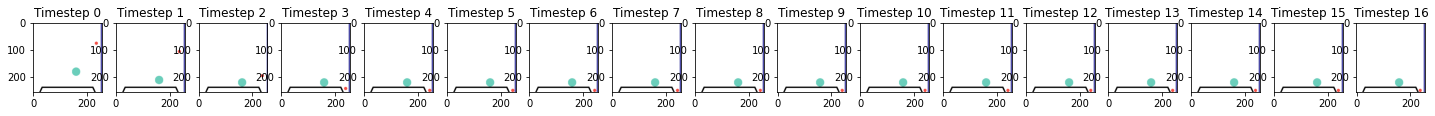

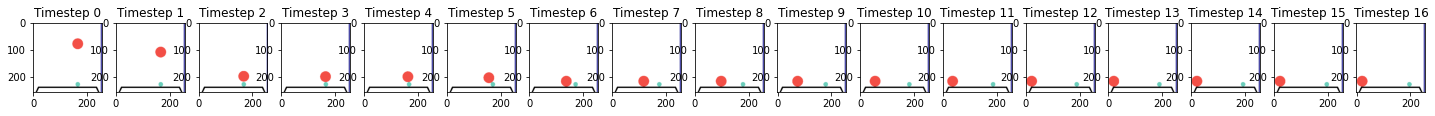

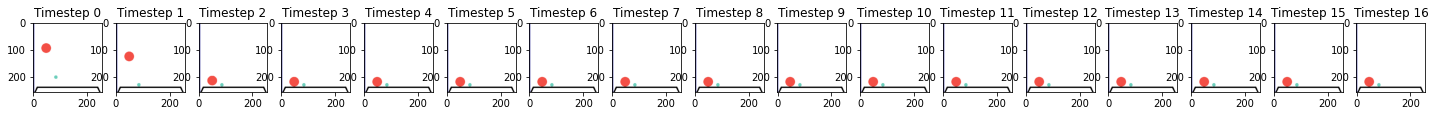

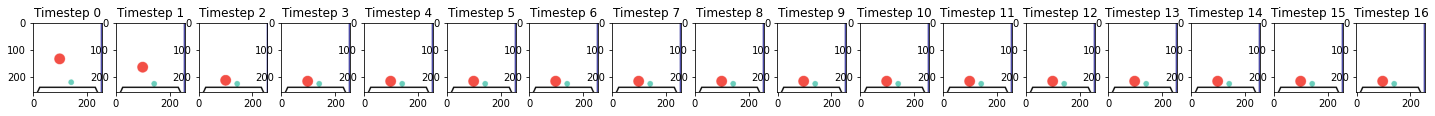

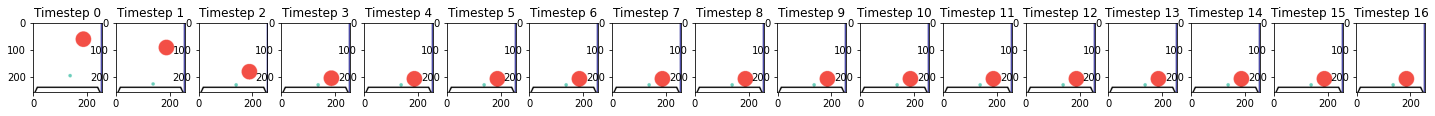

In [148]:
num_across = 17
tasks = train_tasks
simulator = train_simulator
# simulation = None 
rollouts = np.array([])
rollout_num = 1
rollout_results = []

print("Getting frames for", get_n_rollouts, "rollouts")
for _ in range(get_n_rollouts):
    path = os.getcwd() + '/rollout_data/rollout_'+str(rollout_num)
    isdir = os.path.isdir(path)  
    print(path, isdir)
    if isdir == False:    os.mkdir('rollout_data/rollout_'+str(rollout_num))
    task_index =  np.random.choice(100)# The simulator takes an index into simulator.task_ids.
    action = random.choice(actions)

    simulation = simulator.simulate_action(task_index, action, need_images=True, need_featurized_objects=True)
    while simulation.images is None:
        action = random.choice(actions)
        simulation = simulator.simulate_action(task_index, action, need_images=True, need_featurized_objects=True)
    height = 1
    fig, axs = plt.subplots(height, num_across, figsize=(20, 15))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    
    sequence = np.array([])

    # We can visualize the simulation at each timestep.
    for i, (ax, image) in enumerate(zip(axs.flatten(), simulation.images)):

        img = phyre.observations_to_float_rgb(image)
        if len(sequence) == 0: sequence = img.reshape(1, 256, 256, 3)
        else: sequence = np.append(sequence, img.reshape(1, 256, 256, 3), axis=0)
        ax.imshow(img)
        sequence_num = len(sequence)
        filename = 'rollout_data/rollout_' + str(rollout_num) + '/frame_' + str(sequence_num) + '.png'
        matplotlib.image.imsave(filename, img)
        ax.title.set_text(f'Timestep {i}')
        ax.plot()
    
    if len(rollouts) == 0: 
        rollouts = sequence.reshape(1, 17, 256, 256, 3)
    else:
        rollouts = np.append(rollouts, sequence.reshape(1, 17, 256, 256, 3), axis=0)
    
    rollout_result = simulation.status.is_solved()
    rollout_results.append(rollout_result)
    rollout_num += 1



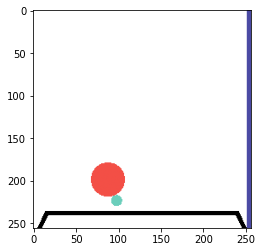

In [129]:
plt.imshow(rollouts[0][0])

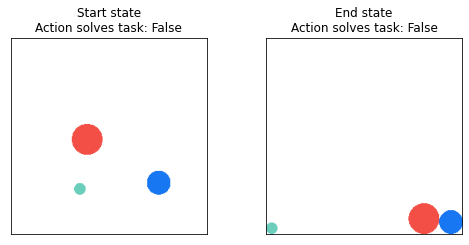

In [13]:
target_status = phyre.SimulationStatus.NOT_SOLVED if simulation.status == phyre.SimulationStatus.SOLVED else phyre.SimulationStatus.SOLVED
bad_action = action
simulation = simulator.simulate_action(task_index, bad_action, need_images=True)
assert simulation.status.is_not_solved()

# Get the start and end state of the simulation.
img_start = phyre.vis.observations_to_float_rgb(simulation.images[0])
img_end = phyre.vis.observations_to_float_rgb(simulation.images[-1])

# Visualize.
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
fig.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axs[0].imshow(img_start)
axs[0].title.set_text(f'Start state\nAction solves task: {simulation.status.is_solved()}')
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])

axs[1].imshow(img_end)
axs[1].title.set_text(f'End state\nAction solves task: {simulation.status.is_solved()}')
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([]);

In [80]:
np.random.choice(10)

0

In [150]:
matplotlib.__version__

'3.3.3'